<a href="https://colab.research.google.com/github/mdaugherity/Numerical2024/blob/main/ode/Week_9_solveivp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, PHYS 351, Fall 2024**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# How to use solve_ivp

You need to specify 3 parameters:
```
solve_ivp(fun, t_span, y0)
```
* fun must take (t,y) where y is scalar or array and return derivatives of y
* t_span = [t0, tf]
* y0 is **array** of initial values (it will not accept scalars)


Other advice:
* always check the message or success variable
* start with RK45 method (or DOP853 for high precision), if it fails try BDF




https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


# EXAMPLE 1 - Simple exponential

$y'(t) = ky$ with an exact solution of  $y(t) = y_0e^{kt}$

This is a step-by-step walkthrough of what solve_ivp does

In [2]:
def yprime(t,y):
  k = 1
  return k*y   # returns derivative of y

y0 = 1
ivp = solve_ivp(yprime, [0,5],[y0])
print(ivp)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01  1.066e+00  2.304e+00  3.645e+00
             5.000e+00]
        y: [[ 1.000e+00  1.105e+00  2.904e+00  1.002e+01  3.829e+01
              1.484e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0


In [3]:
# always check the message (or least the success)
print(ivp.message)

The solver successfully reached the end of the integration interval.


In [4]:
# The results are in the t and y variables
t_ivp = ivp.t
y_ivp = ivp.y[0]  # y is always a 2D array!
print(t_ivp)
print(y_ivp)

[0.         0.10001999 1.06609106 2.30431769 3.64528981 5.        ]
[  1.           1.10519301   2.9040598   10.01740317  38.29174533
 148.39440874]


Notice the steps that *solve_ivp* takes.

Include Euler's method for comparison plots below

In [5]:
def euler(yprime,t,y0):
  '''
  Finds y from Euler's Method.
  INPUT: yprime(t,y) = function of derivatives; t = array of times; y0 = initial value
  '''
  y = np.zeros_like(t)
  y[0] = y0

  for i in range(len(t)-1):
    y[i+1] = y[i] + (t[i+1]-t[i])*yprime(t[i],y[i])

  return y

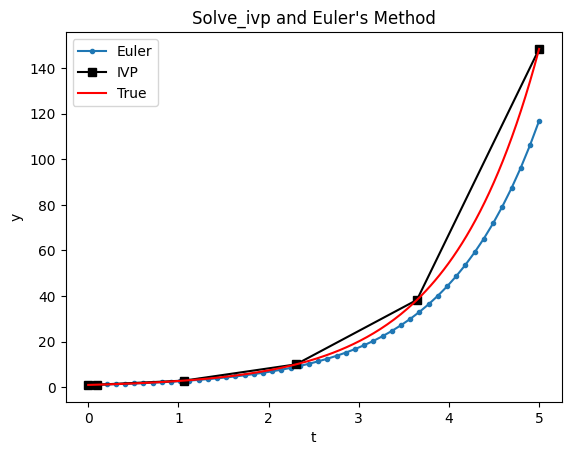

In [6]:
t = np.linspace(0, 5, num=50)
y0 = 1
y = euler(yprime,t,y0)

# Exact
tsol = np.linspace(0,5,200)
k=1
ysol = np.exp(k*tsol)

plt.plot(t,y,'.-',label='Euler')
plt.plot(t_ivp,y_ivp,'ks-',label='IVP')
plt.plot(tsol, ysol, 'r-',label='True')

plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solve_ivp and Euler\'s Method')
plt.show()

In [7]:
print("\tSolution\tError\t\tSteps")
print(f"IVP:\t{y_ivp[-1]:0.6f}\t{y_ivp[-1]-ysol[-1]:0.6f}\t{len(t_ivp)}")
print(f"Euler:\t{y[-1]:0.6f}\t{y[-1]-ysol[-1]:0.6f}\t{len(t)}")

	Solution	Error		Steps
IVP:	148.394409	-0.018750	6
Euler:	116.865497	-31.547662	50


As a fun challenge: try to figure out how many steps Euler needs to get the same accuracy as *solve_ivp* does in 5 steps

# EXAMPLE 2 - Radiative Cooling
From https://nm.mathforcollege.com/mws/gen/08ode/mws_gen_ode_txt_euler.pdf

Here's a single-cell version of calling solve_ivp


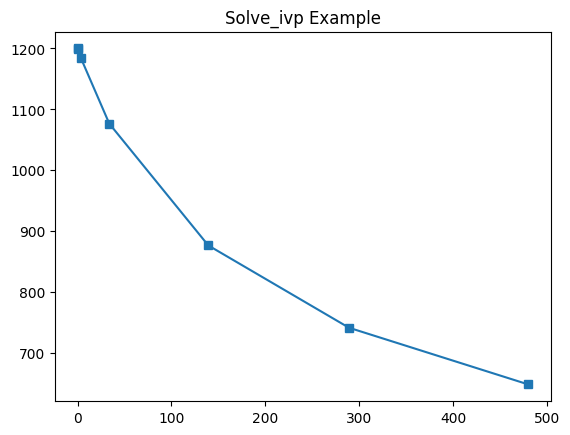

In [8]:
# Define derivative function
def yprime(t,y):
  k = 2.2067e-12
  a = 81e8
  return -k*(y**4 - a)

ivp = solve_ivp(yprime, [0,480],[1200])
t_ivp = ivp.t
y_ivp = ivp.y[0]

plt.title('Solve_ivp Example')
plt.plot(t_ivp,y_ivp,'s-',label='IVP')
plt.show()

# Making Smooth Plots
RK45 is amazingly good at solving problems in a small number of steps, but what if we **want** lots of steps to make a smooth plot?  Here's two methods.



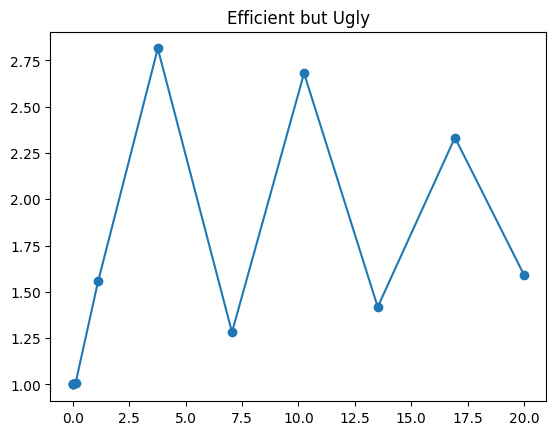

In [9]:
def yprime(t,y):
  return np.sin(t)

ivp = solve_ivp(yprime, [0,20], [1])
t_ivp = ivp.t
y_ivp = ivp.y[0]
plt.title('Efficient but Ugly')
plt.plot(t_ivp, y_ivp,'o-')
plt.show()

## Option 1: The t_eval trick
The default method in solve_ivp is RK45 with an adaptive step size.  We can instead manually choose the steps and pass them into *t_eval*

Solutions
Default:	 1.5927186061203615
t_eval :	 1.592718606120357


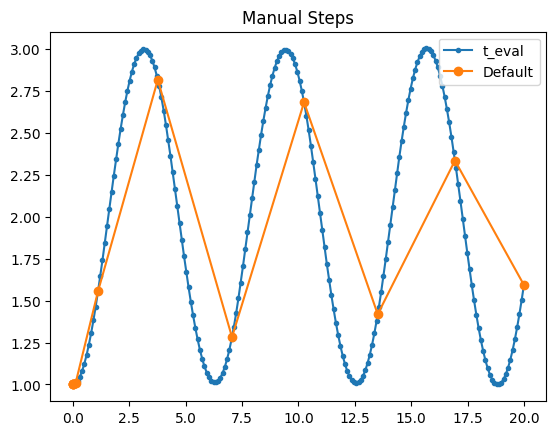

In [10]:
t = np.linspace(0,20,num=200) # Define time axis
ivp = solve_ivp(yprime, [0,20], [1], t_eval=t)  # Use t_eval!
t_ivp2 = ivp.t
y_ivp2 = ivp.y[0]

print('Solutions')
print('Default:\t', y_ivp[-1])
print('t_eval :\t', y_ivp2[-1])

plt.plot(t_ivp2, y_ivp2,'.-', label='t_eval')
plt.plot(t_ivp, y_ivp,'o-', label='Default')
plt.legend()
plt.title('Manual Steps')
plt.show()

## Option 2: dense_output
By setting dense_output=True then solve_ivp will give us an interpolation between the points that we can use.  **This is far more computationally efficient than using t_eval.**

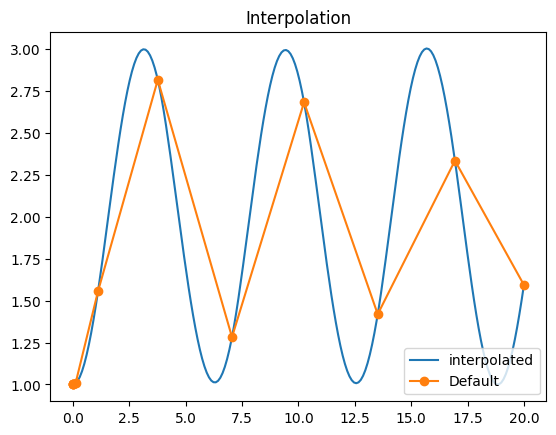

In [11]:
ivp = solve_ivp(yprime, [0,20], [1], dense_output=1)  # dense output
t = np.linspace(0,20,num=200) # Define time axis

plt.plot(t, ivp.sol(t)[0],'-', label='interpolated')
plt.plot(t_ivp, y_ivp,'o-', label='Default')
plt.legend(loc='lower right')
plt.title('Interpolation')
plt.show()

# Coupled-Systems
Now define $y$ as a **vector** $\vec{y}=[y_1, y_2]$.  Then our derivative function must also return a vector  $yprime(t,\vec{y}) = [y'_1,y'_2]$


The solver successfully reached the end of the integration interval.
nfev =  218


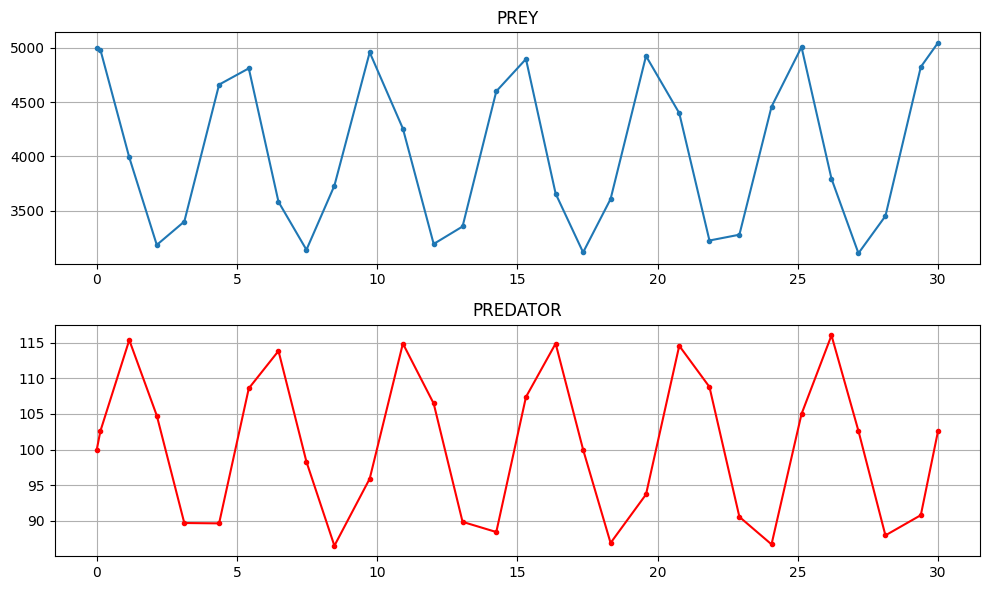

In [12]:
# PRED-PREY
# p1 = prey population, p2 = predator population
a1 = 2.0; a2 = 0.0002; # growth rates
d1 = 0.02; d2 = 0.8; # death rates

def yprime(t,yvec):
  y1 = yvec[0]  # define yvec=[y1,y2]=[prey, predator]
  y2 = yvec[1]
  return [a1*y1-d1*y1*y2,  a2*y1*y2 - d2*y2];

TMAX = 30
y0 = [5000, 100]
ivp = solve_ivp(yprime, [0,TMAX],y0)
print(ivp.message)
print('nfev = ',ivp.nfev)
t = ivp.t
prey = ivp.y[0]
pred = ivp.y[1]

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, prey,'.-',label='y')
plt.grid()
plt.title('PREY')
plt.subplot(2,1,2)
plt.plot(t, pred,'r.-',label='y')
plt.grid()
plt.title('PREDATOR')
plt.tight_layout()
plt.show()

With smooth plots

The solver successfully reached the end of the integration interval.
nfev =  218


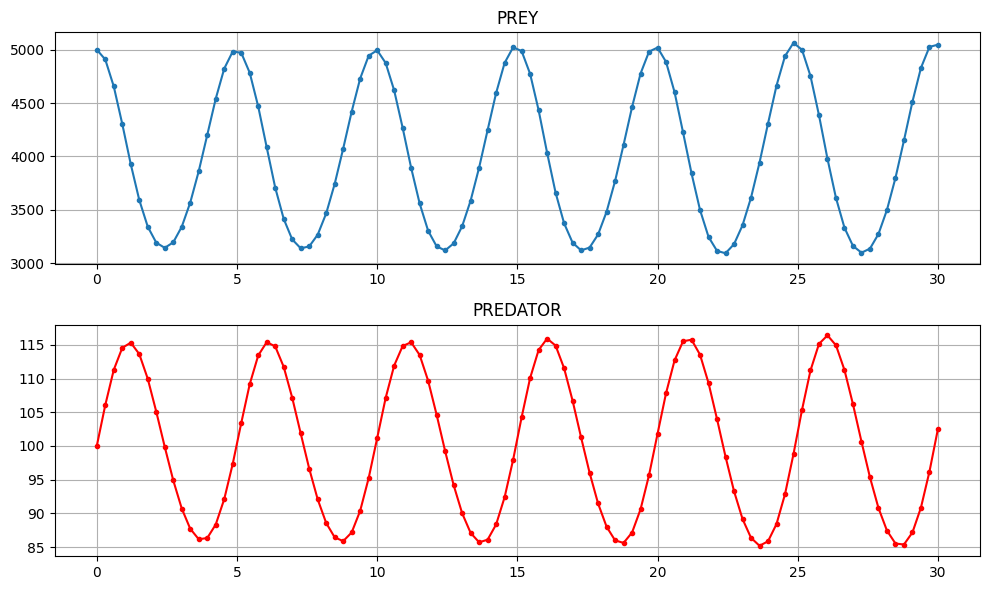

In [13]:
ivp = solve_ivp(yprime, [0,TMAX],y0,dense_output=1)
print(ivp.message)
print('nfev = ',ivp.nfev)

# Interpolate values for plots
t = np.linspace(0, TMAX, num=100)
yint = ivp.sol(t)
prey_int = yint[0]
pred_int = yint[1]

# Plot
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, prey_int,'.-',label='y')
plt.grid()
plt.title('PREY')
plt.subplot(2,1,2)
plt.plot(t, pred_int,'r.-',label='y')
plt.grid()
plt.title('PREDATOR')
plt.tight_layout()
plt.show()

# Higher-Order Problems
2nd (or higher) order problems are solved by "unrolling" into N first-order equations



Define $\vec{y}=[y, y']$.  Then the derivatives $\vec{y}'= yprime(t,\vec{y})=[y', y'']$ where the first derivative trivially points to $y'=\vec{y}[1]$ by definition


## EXAMPLE 4 - Free Fall
Solve the free fall problem:  $y'' = -g$

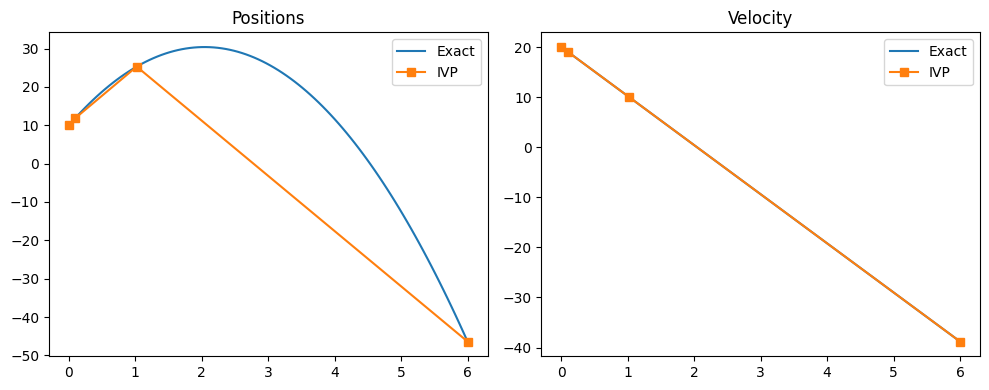

In [14]:
def yprime(t,yvec): # yvec=[y, y']
  y = yvec[0]
  yp = yvec[1]
  return [yp, -9.8]  # returns [y', y'']

tf = 6
y0 = 10
v0 = 20
ivp = solve_ivp(yprime, [0,tf],[y0, v0]   )
t_ivp = ivp.t
y_ivp = ivp.y[0]
v_ivp = ivp.y[1]

# Exact solution
t = np.linspace(0, tf, 100)
y = y0 + v0*t - 0.5*9.8*t**2
v = v0 -9.8*t

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t,y,'-',label='Exact')
plt.plot(t_ivp,y_ivp,'s-',label='IVP')
plt.title('Positions')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t,v,'-',label='Exact')
plt.plot(t_ivp,v_ivp,'s-',label='IVP')
plt.title('Velocity')
plt.legend()

plt.tight_layout()
plt.show()

#EVENTS!!
Sometimes you want to know when your functions reach certain values.  We get this functionality in *solve_ivp* using **events**.  Define a function that takes $(t,y)$ as parameters which returns $0$ at the moment you're interested in.  During every integration step. *solve_ivp* will evaluate your function, and if there is a sign change it will pass this bracket off to a root-finder.

For example, in the free-fall problem suppose we want to know when the ball is at max height or when it hits the ground.  We just need to make event functions to search for when $y(t)=0$ or $y'(t)=0$.


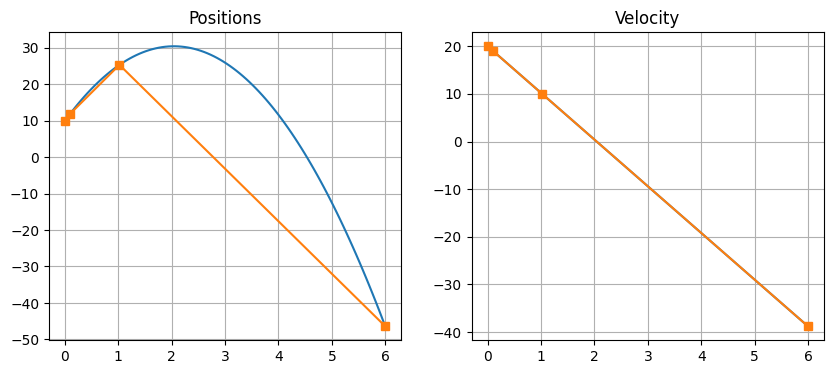

In [15]:
def yprime(t,yvec): # yvec=[y, y']
  y = yvec[0]
  yp = yvec[1]
  return [yp, -9.8]  # returns [y', y'']

def ground_event(t,yvec):   # when do I hit the ground?
  return yvec[0]

def height_event(t,yvec):   # when is max height?
  return yvec[1]

def target_event(t,yvec):   # An arbitrary target: when is y=2.23541235?
  return yvec[0]-2.23541235

tf = 6
y0 = 10
v0 = 20
ivp = solve_ivp(yprime, [0,tf],[y0, v0], events=(ground_event,height_event,target_event)   )
t_ivp = ivp.t
y_ivp = ivp.y[0]
v_ivp = ivp.y[1]

# Exact solution
t = np.linspace(0, tf, 100)
y = y0 + v0*t - 0.5*9.8*t**2
v = v0 -9.8*t

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t,y,'-')
plt.plot(t_ivp,y_ivp,'s-',label='IVP')
plt.title('Positions')
plt.grid()

plt.subplot(1,2,2)
plt.plot(t,v,'-')
plt.plot(t_ivp,v_ivp,'s-',label='IVP')
plt.title('Velocity')
plt.grid()
plt.show()

In [16]:
ivp

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.276e-02  1.020e+00  6.000e+00]
        y: [[ 1.000e+01  1.181e+01  2.531e+01 -4.640e+01]
            [ 2.000e+01  1.909e+01  1.000e+01 -3.880e+01]]
      sol: None
 t_events: [array([ 4.532e+00]), array([ 2.041e+00]), array([ 4.439e+00])]
 y_events: [array([[ 7.105e-15, -2.441e+01]]), array([[ 3.041e+01,  5.329e-15]]), array([[ 2.235e+00, -2.350e+01]])]
     nfev: 20
     njev: 0
      nlu: 0

In [17]:
print('Time at hitting the ground = ',ivp.t_events[0][0])
print('Velocity at hitting the ground = ', ivp.y_events[0][0][1])
print('Time at max height = ',ivp.t_events[1][0])

Time at hitting the ground =  4.531950125659942
Velocity at hitting the ground =  -24.413111231467447
Time at max height =  2.040816326530612


# Stiff Problems
Last thing to know about *solve_ivp*: you should always start with the default rk45 method, but you can change if necessary.  Some solvers work better on stiff problems or problems needing high accuracy.  

Methods:
* rk45: default, always try this one first
* BDF: try this next if rk45 fails or takes too long
* DOP853: 8th order method, use this for high accuracy (default values are 1e-3 for rtol and 1e-6 for atol)

Check documentation for more details: Default values are 1e-3 for rtol and 1e-6 for atol.



Method:  RK45
The solver successfully reached the end of the integration interval.
nfev =  428
num points =  69

Method:  BDF
The solver successfully reached the end of the integration interval.
nfev =  74
num points =  37

Method:  Radau
The solver successfully reached the end of the integration interval.
nfev =  107
num points =  16


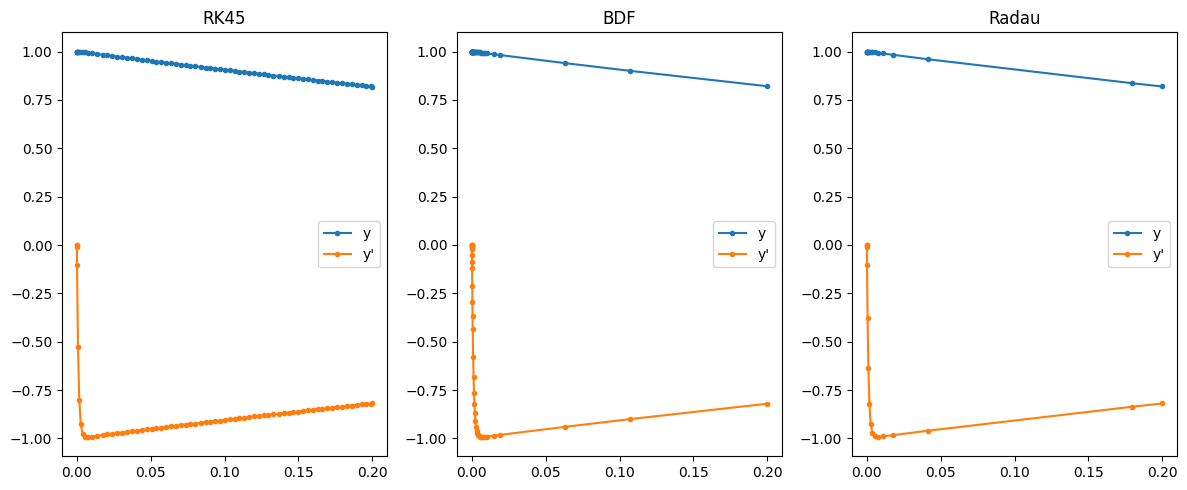

In [18]:
def yprime(t,y):
  return [y[1], -1001*y[1] - 1000*y[0]]

y0 = [1,0]
TMAX = 0.2

METHODS = ['RK45','BDF','Radau']
plt.figure(figsize=(12,5))
for i in range(len(METHODS)):
  plt.subplot(1,3,i+1)
  m = METHODS[i]
  ivp = solve_ivp(yprime, [0,TMAX],y0,method=m)
  t = ivp.t
  y = ivp.y[0]
  yp = ivp.y[1]

  print('\nMethod: ',m)
  print(ivp.message)
  print('nfev = ',ivp.nfev)
  print('num points = ',len(t))

  plt.plot(t, y,'.-',label='y')
  plt.plot(t, yp, '.-',label='y\'')
  plt.legend()
  plt.title(m)

plt.tight_layout()
plt.show()